In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
#Read Unemployment file

df = pd.read_excel('UR_data.xlsx')

df.head

<bound method NDFrame.head of           Date  UNRATE
0   1948-01-01     3.4
1   1948-02-01     3.8
2   1948-03-01     4.0
3   1948-04-01     3.9
4   1948-05-01     3.5
..         ...     ...
909 2023-10-01     3.8
910 2023-11-01     3.7
911 2023-12-01     3.7
912 2024-01-01     3.7
913 2024-02-01     3.9

[914 rows x 2 columns]>

In [3]:
df.columns

Index(['Date', 'UNRATE'], dtype='object')

In [4]:
df.set_index('Date', inplace = True)
df.head

<bound method NDFrame.head of             UNRATE
Date              
1948-01-01     3.4
1948-02-01     3.8
1948-03-01     4.0
1948-04-01     3.9
1948-05-01     3.5
...            ...
2023-10-01     3.8
2023-11-01     3.7
2023-12-01     3.7
2024-01-01     3.7
2024-02-01     3.9

[914 rows x 1 columns]>

In [5]:
#Set the dataset to train
from_date = '1948-01-01'
to_date = '2024-02-01'

UR = df['UNRATE'].loc[from_date:to_date].values

In [6]:
#Train the SARIMA model
train, test = UR[:-1], UR[-1]

#Lag by 3 periods, differencing order = 1, moving average window = 1
#seasonal_order set to 0 indicating no seasons
model = SARIMAX(train, order =(3,1,1), seasonal_order = (0,0,0,0))

SAR_results = model.fit(disp = 1)
SAR_forecast = SAR_results.forecast()
SAR_predicted = SAR_forecast[0]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.47170D-01    |proj g|=  5.29053D-03

At iterate    1    f=  5.47168D-01    |proj g|=  1.71118D-03

At iterate    2    f=  5.47168D-01    |proj g|=  1.51749D-03

At iterate    3    f=  5.47165D-01    |proj g|=  1.39463D-03

At iterate    4    f=  5.47163D-01    |proj g|=  1.77156D-03

At iterate    5    f=  5.47154D-01    |proj g|=  2.89444D-03

At iterate    6    f=  5.47132D-01    |proj g|=  5.86816D-03

At iterate    7    f=  5.47058D-01    |proj g|=  1.25040D-02

At iterate    8    f=  5.46846D-01    |proj g|=  3.66820D-02

At iterate    9    f=  5.46587D-01    |proj g|=  3.24898D-02

At iterate   10    f=  5.45813D-01    |proj g|=  3.43608D-02

At iterate   11    f=  5.45206D-01    |proj g|=  1.08728D-02

At iterate   12    f=  5.45129D-01    |proj g|=  2.24284D-02

At iterate   13    f=  5.4

 This problem is unconstrained.


In [7]:
#Print results
print(f'Predicted SARIMA UR on {to_date}: {round(SAR_predicted, 1)}')
print(f'Actual SARIMA UR on {to_date}: {round(test, 1)}')

Predicted SARIMA UR on 2024-02-01: 3.7
Actual SARIMA UR on 2024-02-01: 3.9


In [8]:
#HWES model
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [9]:
#Train HWES model
train, test = UR[:-1], UR[-1]
model = ExponentialSmoothing(train)

HWES_results = model.fit()

HWES_forecast = HWES_results.forecast()
HWES_predicted = HWES_forecast[0]

In [10]:
#Print results
print(f'Predicted HWES UR on {to_date}: {round(HWES_predicted, 1)}')
print(f'Actual HWES UR on {to_date}: {round(test, 1)}')

Predicted HWES UR on 2024-02-01: 3.7
Actual HWES UR on 2024-02-01: 3.9


In [11]:
#RNN Model
import torch.nn as nn
import torch
from sklearn.preprocessing import MinMaxScaler

In [12]:
#Code to load the data and return function
def get_unrate_ts():
    rnn_df = pd.read_csv('UR_data.csv')
    #transform the dataset to work with scaler
    ts = rnn_df['UNRATE'].astype(int).values.reshape(-1,1)
    return ts

In [13]:
#print the shape of the dataset
ts = get_unrate_ts()
print(f"Shape of ts: {ts.shape}")

Shape of ts: (914, 1)


In [14]:
#RNN class
class RNN(nn.Module):

    def __init__(self,
                 hidden_size,
                 in_size = 1,
                 out_size = 1):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size = in_size,
            hidden_size = hidden_size,
            batch_first = True)
        self.fc = nn.Linear(hidden_size, out_size)

    def forward(self, x, h = None):
        out, _ = self.rnn(x, h)
        last_hidden_states = out[:, -1]
        out = self.fc(last_hidden_states)
        return out, last_hidden_states

In [15]:
# length of sliding window
features = 2 #'Date' and 'UNRATE'

# length of test dataset
test_ts_len = 150

# size of RNN hidden state
rnn_hidden_size = 24

#Optimizer learning rate
learning_rate = 0.02
training_epochs = 500

In [16]:
#Get Training datasets code
def get_training_datasets(ts, features, test_len):
    X, Y = sliding_window(ts, features)

    X_train, Y_train, X_test, Y_test = X[0:-test_len],\
                                       Y[0:-test_len],\
                                       X[-test_len:],\
                                       Y[-test_len:]

    train_len = round(len(ts) * 0.70)

    # Ensure at least one element remains for validation after training split
    #val_len = max(len(X_train) - train_len, 1)  # Take max to avoid negative value
    
    X_train, X_val, Y_train, Y_val = X_train[0:train_len],\
                                     X_train[train_len:],\
                                     Y_train[0:train_len],\
                                     Y_train[train_len:]

    # Print the lengths for debugging
    print(f"Length of X_train: {len(X_train)}")
    print(f"Length of X_val: {len(X_val)}")
    print(f"Length of X_test: {len(X_test)}")
    
    x_train = torch.tensor(data = X_train).float()
    y_train = torch.tensor(data = Y_train).float()

    x_val = torch.tensor(data = X_val).float()
    y_val = torch.tensor(data = Y_val).float()

    x_test = torch.tensor(data = X_test).float()
    y_test = torch.tensor(data = Y_test).float()

    return x_train, x_val, x_test,\
           y_train.squeeze(1), y_val.squeeze(1), y_test.squeeze(1)

In [17]:
#Get sliding window code
def sliding_window(ts, features):
    X = []
    Y = []

    for i in range(features + 1, len(ts) + 1):
        X.append(ts[i - (features + 1):i - 1])
        Y.append(ts[i - 1])  # Directly append the target value

    return X, Y

In [18]:
#Scale the dataset for training
ts = get_unrate_ts()

scaler = MinMaxScaler()
scaled_ts = scaler.fit_transform(ts)

x_train, x_val, x_test, y_train, y_val, y_test =get_training_datasets(scaled_ts, features, test_ts_len)

Length of X_train: 640
Length of X_val: 122
Length of X_test: 150


/var/folders/pr/r9s7fv8d3hl7zl078q3rzs_00000gn/T/ipykernel_21281/1431604950.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  x_train = torch.tensor(data = X_train).float()


In [19]:
# Initialize the RNN model
model = RNN(hidden_size = rnn_hidden_size)
model.train()

RNN(
  (rnn): RNN(1, 24, batch_first=True)
  (fc): Linear(in_features=24, out_features=1, bias=True)
)

In [20]:
import sys
import copy

# Train the RNN model
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)
mse_loss = torch.nn.MSELoss()
best_model = None
min_val_loss = sys.maxsize

training_loss = []
validation_loss = []

for t in range(training_epochs):
    
    prediction, _ = model(x_train) #_ means store the 1st element for prediction and disgard the 2nd element.
    
    #Reshape y_train to match prediction before calculating loss
    y_train_reshaped = y_train.unsqueeze(1)  # Add a new dimension of size 1
    
    loss = mse_loss(prediction, y_train_reshaped) #added y_train_reshaped
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    val_prediction, _ = model(x_val)
    val_loss = mse_loss(val_prediction, y_val)
    
    training_loss.append(loss.item())
    validation_loss.append(val_loss.item())
    
    if val_loss.item() < min_val_loss:
        best_model = copy.deepcopy(model)
        min_val_loss = val_loss.item()
        
    if t % 50 == 0:
        print(f'epoch {t}: train - {round(loss.item(), 4)}', f'val: - {round(val_loss.item(), 4)}')

epoch 0: train - 0.3762 val: - 0.1557
epoch 50: train - 0.0014 val: - 0.0521
epoch 100: train - 0.0011 val: - 0.047
epoch 150: train - 0.0011 val: - 0.0469
epoch 200: train - 0.0011 val: - 0.047
epoch 250: train - 0.0011 val: - 0.0471
epoch 300: train - 0.0011 val: - 0.0472


/Users/ryak/anaconda3/envs/dev/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([122])) that is different to the input size (torch.Size([122, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 350: train - 0.0011 val: - 0.0472
epoch 400: train - 0.0011 val: - 0.0473
epoch 450: train - 0.0011 val: - 0.0474


In [21]:
#Evaluate the RNN Model: Pass the 'warm'hidden state through each iteration

best_model.eval() # set to evaluation mode - disables dropout and normalization, etc.

_, h_list = best_model(x_val) #evaluates the best model on the x_val (validation set)

# Warm hidden state
h = (h_list[-1, :]).unsqueeze(-2) #.unsqueeze reshapes tensor to match the input shape of model. 
rnn_predicted =[]

for test_seq in x_test.tolist():
    
    x = torch.Tensor(data = [test_seq]) #each test_seq represents a sequence of input data.
    
    # Passing hidden state through each iteration
    y, h = best_model(x, h.unsqueeze(-2)) #x is current input and warm hidden state is h.
    
    unscaled = scaler.inverse_transform(np.array(y.item()).reshape(-1,1))[0][0]
    #inversely scales the predicted y to its original scale and np.reshapes the 1D array into a 2D array with 1 column for the scaler.
    
    rnn_predicted.append(unscaled)

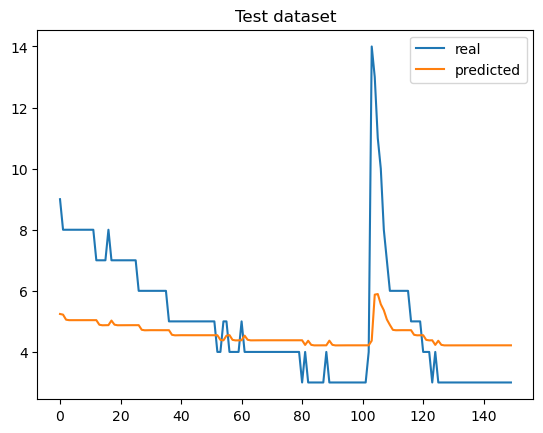

In [22]:
# Performance on the test dataset

real = scaler.inverse_transform(y_test.reshape(-1, 1))
#inversely scales the y_test to original scale and converts it to a python list to display in visualization

plt.title("Test dataset")
plt.plot(real, label = 'real')
plt.plot(rnn_predicted, label = 'predicted')
plt.legend()
plt.show()

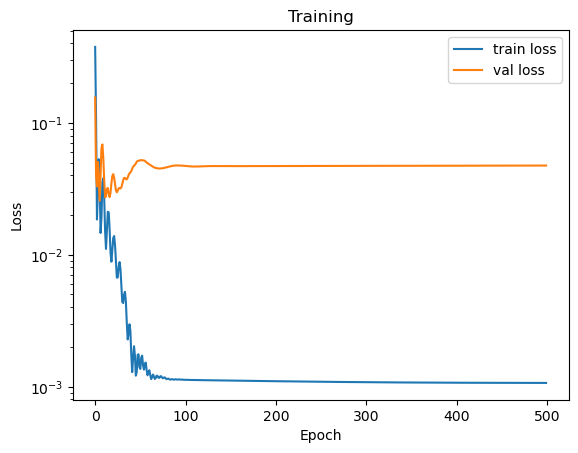

In [23]:
# Examine RNN training process

plt.title("Training")
plt.yscale('log')
plt.plot(training_loss, label = "train loss")
plt.plot(validation_loss, label = "val loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [24]:
# Attempt at calculating the best model MSE
from sklearn.metrics import mean_squared_error

best_model.eval()
test_prediction, _ = best_model(x_test)

#Convert tensors to numpy arrays
y_test_np = y_test.detach().numpy()
test_prediction_np = test_prediction.detach().numpy()

# Calculating the accuracy score
#threshold = 0.1
mse = mean_squared_error(y_test_np, test_prediction_np)

print(f"RNN MSE: {mse}")

RNN MSE: 0.025092890486121178


In [25]:
#Attempt at calculating the best model R-squared score
from sklearn.metrics import r2_score

r2 = r2_score(y_test_np, test_prediction_np)

print(f"RNN R-Squared: {r2}")

RNN R-Squared: 0.13634574285155066


#Lookup TimeSeriesTransformer

In [26]:
#Improve the SARIMA model to produce multiple predictions and graph them

#UR is the dataset and specific time period
from_date = '1948-01-01'
to_date = '2024-02-01'

UR = df['UNRATE'].loc[from_date:to_date].values

#Train the SARIMA model, but split the train and test sets
split_ratio = 0.80 #80% for training
train_size = int(len(UR) * split_ratio)
train, test = UR[:train_size], UR[train_size:]

#Lag by 3 periods, differencing order = 1, moving average window = 1
#seasonal_order set to 0 indicating no seasons
model = SARIMAX(train, order =(3,2,1), seasonal_order = (0,0,0,0))

#specific length of forecast in # of steps
steps_to_forecast = 12 #12 months

SAR_results = model.fit(disp = True)

#Define steps to forecast and change to float
SAR_forecast = SAR_results.forecast(steps = steps_to_forecast).astype(float)

SAR_predicted = SAR_forecast

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.90509D-01    |proj g|=  4.12235D+00

At iterate    1    f=  1.45638D-01    |proj g|=  5.08380D-01

At iterate    2    f=  8.26772D-02    |proj g|=  5.10742D-01

At iterate    3    f=  1.25267D-02    |proj g|=  1.29687D+00

At iterate    4    f= -5.07579D-02    |proj g|=  1.80694D+00

At iterate    5    f= -1.28179D-01    |proj g|=  1.75056D-01

At iterate    6    f= -1.37901D-01    |proj g|=  1.41868D-01

At iterate    7    f= -1.48159D-01    |proj g|=  2.78294D-01

At iterate    8    f= -1.50411D-01    |proj g|=  3.38282D-02

At iterate    9    f= -1.50605D-01    |proj g|=  2.14902D-02

At iterate   10    f= -1.50693D-01    |proj g|=  2.80074D-02

At iterate   11    f= -1.50998D-01    |proj g|=  3.85858D-02

At iterate   12    f= -1.51158D-01    |proj g|=  2.51007D-02

At iterate   13    f= -1.5

/Users/ryak/anaconda3/envs/dev/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/ryak/anaconda3/envs/dev/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


In [27]:
#Print the SAR_predicted values for the forecast into the future
print(SAR_predicted)

[6.91671785 7.07512324 7.16770162 7.23645187 7.29472056 7.33444738
 7.36661224 7.39176597 7.41137284 7.42760966 7.44101805 7.45245519]


## THIS SARIMA CODE IS WORKING: LOOK AT THE FORECASTS AND THE PARAMETERS

In [28]:
#Trying SARIMA with orginal code and attempting to forecast 12 months into the future

#Set the dataset to train
from_date = '1948-01-01'
to_date = '2024-02-01'

UR = df['UNRATE'].loc[from_date:to_date].values

#Train the SARIMA model
train, test = UR[:-12], UR[-12] #Exclude the last 12 months from training

#Lag by 3 periods, differencing order = 1, moving average window = 2
#seasonal_order set to 0 indicating no seasons
model = SARIMAX(train, order =(3,1,3), seasonal_order = (0,0,0,0))

SAR_results = model.fit(disp = 1)
SAR_forecast = SAR_results.forecast(steps = 12)
SAR_predicted = SAR_forecast

# Print or use the predictions as needed
for i in range(12):
    predicted_date = pd.to_datetime(to_date) + pd.DateOffset(months=i)
    print(f"Predicted SARIMA UR on {predicted_date}: {round(SAR_predicted[i], 2)}")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.50593D-01    |proj g|=  2.32565D-02

At iterate    1    f=  5.50561D-01    |proj g|=  5.24066D-03

At iterate    2    f=  5.50555D-01    |proj g|=  4.39106D-03

At iterate    3    f=  5.50537D-01    |proj g|=  1.69713D-03

At iterate    4    f=  5.50533D-01    |proj g|=  1.94188D-03

At iterate    5    f=  5.50499D-01    |proj g|=  3.40441D-03

At iterate    6    f=  5.50467D-01    |proj g|=  3.63116D-03

At iterate    7    f=  5.50394D-01    |proj g|=  5.61491D-03

At iterate    8    f=  5.50382D-01    |proj g|=  5.46009D-03

At iterate    9    f=  5.50349D-01    |proj g|=  2.07005D-03

At iterate   10    f=  5.50345D-01    |proj g|=  5.73217D-04

At iterate   11    f=  5.50345D-01    |proj g|=  2.33454D-04

At iterate   12    f=  5.50344D-01    |proj g|=  3.60466D-04

At iterate   13    f=  5.5

 This problem is unconstrained.



At iterate   20    f=  5.50037D-01    |proj g|=  7.69600D-02

At iterate   21    f=  5.49997D-01    |proj g|=  8.52351D-02

At iterate   22    f=  5.49800D-01    |proj g|=  7.79687D-02

At iterate   23    f=  5.48959D-01    |proj g|=  1.75914D-02

At iterate   24    f=  5.48756D-01    |proj g|=  5.00965D-02

At iterate   25    f=  5.48561D-01    |proj g|=  4.68400D-02

At iterate   26    f=  5.47866D-01    |proj g|=  1.85116D-02

At iterate   27    f=  5.47545D-01    |proj g|=  1.05925D-02

At iterate   28    f=  5.47111D-01    |proj g|=  5.32875D-03

At iterate   29    f=  5.46592D-01    |proj g|=  3.30784D-02

At iterate   30    f=  5.46251D-01    |proj g|=  2.39687D-02

At iterate   31    f=  5.45682D-01    |proj g|=  1.07692D-02

At iterate   32    f=  5.45389D-01    |proj g|=  6.72287D-03

At iterate   33    f=  5.45245D-01    |proj g|=  1.07844D-02

At iterate   34    f=  5.45235D-01    |proj g|=  2.65540D-03

At iterate   35    f=  5.45229D-01    |proj g|=  2.35292D-03

At iter

/Users/ryak/anaconda3/envs/dev/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


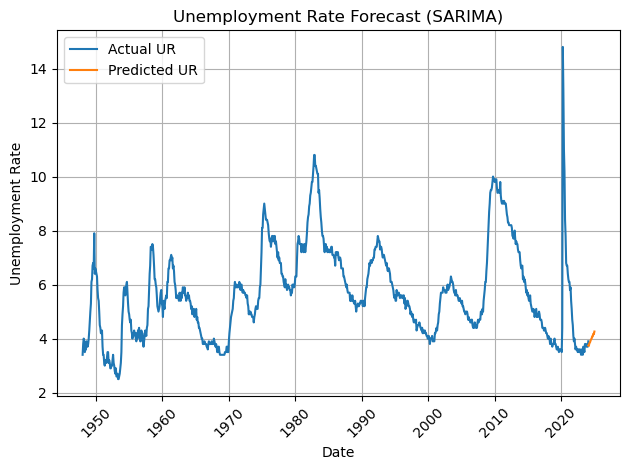

In [29]:
#Plot the predicted SARIMA UR rates

# Extract actual unemployment rate (if available) for comparison (optional)
actual_UR = df['UNRATE'].loc[from_date: pd.to_datetime(to_date) + pd.DateOffset(months=11)]  # Include one extra month for plotting

# Generate predicted dates for plotting
predicted_dates = [pd.to_datetime(to_date) + pd.DateOffset(months=i) for i in range(12)]  # Adjust for 12-month forecast

# Plot actual UR (if available)
if 'actual_UR' in locals():
  plt.plot(actual_UR.index, actual_UR.values, label='Actual UR')

# Plot predicted UR
plt.plot(predicted_dates, SAR_predicted, label='Predicted UR')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.title('Unemployment Rate Forecast (SARIMA)')

# Add legend (if actual UR is plotted)
if 'actual_UR' in locals():
  plt.legend()

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

## ATTEMPT AT OPTUNA TRIAL FOR SARIMA FORECAST MODEL

In [30]:
import optuna
from sklearn.metrics import mean_absolute_error

In [31]:
#Load the data into the trial:
from_date = '1948-01-01'
to_date = '2024-02-01'

UR = df['UNRATE'].loc[from_date:to_date].values

#Reshape the data for 2-D array
#UR = UR.reshape(-1, 1)

#Optuna trial:
def objective(trial, UR):
    
    # Suggest p, d, q values within a reasonable range
    p = trial.suggest_int("p", 0, 12)
    d = trial.suggest_int("d", 0, 12)
    q = trial.suggest_int("q", 0, 12)
    
    # Train the SARIMA model with suggested parameters
    train, test = UR[:-12], UR[-12:]
    model = SARIMAX(train, order=(p, d, q)) #Note: do NOT try to trial seasonal parameters! 
    model_fit = model.fit(disp=0)
    
    # Calculate Mean Absolute Error (MAE)
    # Generate predictions for the test set
    preds = model_fit.forecast(steps=12)  # Obtain predictions
    mae = mean_absolute_error(test, preds)  # Calculate MAE

    return mae  # Return MAE for optimization

# Optuna study
study = optuna.create_study(
    storage ="sqlite:///SARIMA.sqlite3",
    study_name = "SARIMA_20")

# Optimize Study
study.optimize(lambda trial: objective(trial, UR), n_trials=50)

#Access best params and best trial
best_params = study.best_params
best_trial = study.best_trial

In [32]:
print(type(UR), UR.shape)

<class 'numpy.ndarray'> (914,)


In [33]:
print(best_params)

{'p': 5, 'd': 3, 'q': 1}


In [34]:
print(best_trial)

FrozenTrial(number=30, state=TrialState.COMPLETE, values=[0.09621682394199345], datetime_start=datetime.datetime(2024, 4, 13, 8, 26, 3, 267733), datetime_complete=datetime.datetime(2024, 4, 13, 8, 26, 3, 990512), params={'p': 5, 'd': 3, 'q': 1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'p': IntDistribution(high=12, log=False, low=0, step=1), 'd': IntDistribution(high=12, log=False, low=0, step=1), 'q': IntDistribution(high=12, log=False, low=0, step=1)}, trial_id=439, value=None)


## SARIMA MODEL WITH OPTUNA TRIAL OPTIMIZED PARAMETERS:12 MONTH FORECAST

In [36]:
#Train the SARIMA model
train, test = UR[:-12], UR[-12] #Exclude the last 12 months from training

#NEW:
# Seasonal_order: p=seasonal auto regressive, d=seasonal differencing, q=seasonal moving average, s=seasonality
seasonal_order = (1, 0, 1, 12)  # (p, d, q, s) #assumes December seasonality

#OPTUNA Best trial parameters: 7=lag, 4=difference_order, 3=moving_average
model = SARIMAX(train, order =(7,4,3), seasonal_order = seasonal_order)

SAR_results = model.fit(disp = 1)
SAR_forecast = SAR_results.forecast(steps = 12)
SAR_predicted = SAR_forecast

# Print or use the predictions as needed
for i in range(24):
    predicted_date = pd.to_datetime(to_date) + pd.DateOffset(months=i)
    print(f"Predicted SARIMA UR on {predicted_date}: {round(SAR_predicted[i], 2)}")

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58583D+00    |proj g|=  2.14799D+00

At iterate    1    f=  1.44284D+00    |proj g|=  4.40140D-01

At iterate    2    f=  1.17065D+00    |proj g|=  2.80332D-01

At iterate    3    f=  1.12097D+00    |proj g|=  2.34456D-01

At iterate    4    f=  1.08736D+00    |proj g|=  2.61774D-01

At iterate    5    f=  1.00470D+00    |proj g|=  4.88728D-01

At iterate    6    f=  9.05162D-01    |proj g|=  1.71066D-01

At iterate    7    f=  8.80058D-01    |proj g|=  2.49313D-01

At iterate    8    f=  8.49485D-01    |proj g|=  1.11771D-01

At iterate    9    f=  8.36148D-01    |proj g|=  5.94894D-02

At iterate   10    f=  8.34685D-01    |proj g|=  9.05366D-02

At iterate   11    f=  8.31225D-01    |proj g|=  3.60382D-02

At iterate   12    f=  8.30349D-01    |proj g|=  2.16443D-02

At iterate   13    f=  8.2

/Users/ryak/anaconda3/envs/dev/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.37213D-01    |proj g|=  5.46660D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     85      1     0     0   5.467D-03   6.372D-01
  F =  0.63721315427412784     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Predicted SARIMA UR on 2024-02-01 00:00:00: 3.63
Predicted SARIMA UR on 2024-03-01 00:00:00: 3.56
Predicted SARIMA UR on 2024-04-01 00:00:00: 3.6
Predicted SARIMA UR on 2024-05-01 00:00:00: 3.61
Predicted SARIMA UR on 2024-06-01 00:00:00: 3.63
Predicted SARIMA UR on 2024-07-01 00:00:00: 3.66
Predicted SARIMA UR on 2024-08-01 00:00:00: 3.71
Predicted SARIMA UR

IndexError: index 12 is out of bounds for axis 0 with size 12

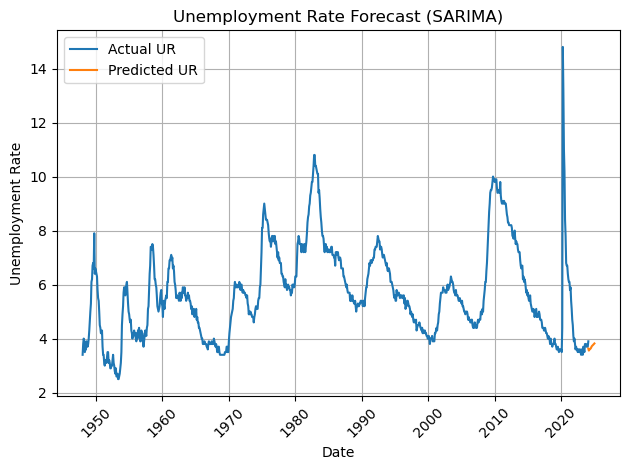

In [37]:
#Graph the 12 month predictions for Unemployment with SARIMA model

# Extract actual unemployment rate (if available) for comparison (optional)
actual_UR = df['UNRATE'].loc[from_date: pd.to_datetime(to_date) + pd.DateOffset(months=11)]  # Include one extra month for plotting

# Generate predicted dates for plotting
predicted_dates = [pd.to_datetime(to_date) + pd.DateOffset(months=i) for i in range(12)]  # Adjust for 12-month forecast

# Plot actual UR (if available)
if 'actual_UR' in locals():
  plt.plot(actual_UR.index, actual_UR.values, label='Actual UR')

# Plot predicted UR
plt.plot(predicted_dates, SAR_predicted, label='Predicted UR')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.title('Unemployment Rate Forecast (SARIMA)')

# Add legend (if actual UR is plotted)
if 'actual_UR' in locals():
  plt.legend()

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

/Users/ryak/anaconda3/envs/dev/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


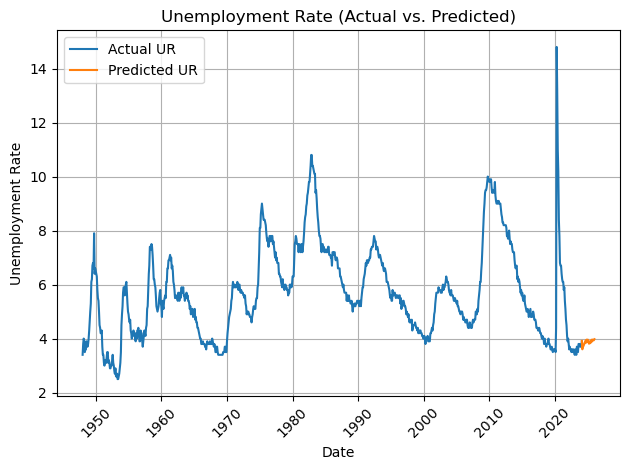

In [38]:
#Attempt to calculate the 24 month predictions and graph AGAINST actual

#Train the SARIMA model
train, test = UR[:-24], UR[-24] #Exclude the last 24 months from training

# Seasonal Order (assuming seasonality in December)
seasonal_order = (1, 0, 1, 12)  # (p, d, q, s)

# Best trial parameters from Optuna (replace with your best parameters)
model = SARIMAX(train, order=(7, 2, 3), seasonal_order=seasonal_order)

# Fit the SARIMA model
SAR_results = model.fit(disp=0)

# Forecast for the next 24 months
SAR_forecast = SAR_results.forecast(steps=24)
SAR_predicted = SAR_forecast

# Extract actual unemployment rate for comparison
actual_UR = df['UNRATE'].loc[from_date: to_date]

# Generate predicted dates for plotting
predicted_dates = [pd.to_datetime(to_date) + pd.DateOffset(months=i) for i in range(24)]

# Plot actual and predicted unemployment rates
plt.plot(actual_UR.index, actual_UR.values, label='Actual UR')
plt.plot(predicted_dates, SAR_predicted, label='Predicted UR')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.title('Unemployment Rate (Actual vs. Predicted)')

# Add legend
plt.legend()

# Rotate x-axis labels for readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
print(SAR_predicted)

[3.91484527 3.60387833 3.74605546 3.72086128 3.79005059 3.84510452
 3.82858564 3.93303107 3.85349282 3.96422107 3.87267355 3.96071503
 3.90551334 3.81210951 3.85720339 3.82683709 3.91947767 3.85886162
 3.96033557 3.899994   3.96287914 3.94094648 3.93923794 3.97835551]


## 2nd ROUND OF SARIMA: Optuna Trial for 24 months, 100 trials

In [40]:
#Load the data into the trial:
from_date = '1948-01-01'
to_date = '2024-02-01'

UR = df['UNRATE'].loc[from_date:to_date].values

#Optuna trial #2: 24 months forecast
def objective(trial, UR):
    
    # Suggest p, d, q values within a reasonable range
    p = trial.suggest_int("p", 0, 12)
    d = trial.suggest_int("d", 0, 12)
    q = trial.suggest_int("q", 0, 12)
    
    # Train the SARIMA model with suggested parameters
    train, test = UR[:-24], UR[-24:]
    model = SARIMAX(train, order=(p, d, q)) #Note: do NOT try to trial seasonal parameters! 
    model_fit = model.fit(disp=0)
    
    # Calculate Mean Absolute Error (MAE)
    # Generate predictions for the test set
    preds = model_fit.forecast(steps=24)  # Obtain predictions
    mae = mean_absolute_error(test, preds)  # Calculate MAE

    return mae  # Return MAE for optimization

# Optuna study
study = optuna.create_study(
    storage ="sqlite:///SARIMA_2.sqlite3",
    study_name = "SARIMA_04")

# Optimize Study
study.optimize(lambda trial: objective(trial, UR), n_trials=50)

#Access best params and best trial
best_params = study.best_params
best_trial = study.best_trial

[I 2024-04-13 08:47:23,602] A new study created in RDB with name: SARIMA_04
/Users/ryak/anaconda3/envs/dev/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2024-04-13 08:47:33,377] Trial 0 finished with value: 40.10793866749993 and parameters: {'p': 8, 'd': 6, 'q': 5}. Best is trial 0 with value: 40.10793866749993.
/Users/ryak/anaconda3/envs/dev/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/ryak/anaconda3/envs/dev/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2024-04-13 08:47:43,39

In [41]:
print(best_params)

{'p': 9, 'd': 2, 'q': 10}


In [42]:
print(best_trial)

FrozenTrial(number=43, state=TrialState.COMPLETE, values=[0.11744754160476943], datetime_start=datetime.datetime(2024, 4, 13, 9, 11, 59, 441803), datetime_complete=datetime.datetime(2024, 4, 13, 9, 12, 2, 870267), params={'p': 9, 'd': 2, 'q': 10}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'p': IntDistribution(high=12, log=False, low=0, step=1), 'd': IntDistribution(high=12, log=False, low=0, step=1), 'q': IntDistribution(high=12, log=False, low=0, step=1)}, trial_id=221, value=None)


## SARIMA Optuna 24 month trial, now 24 month projection. Compare MSE score for 12 month which was 0.10% error versus 0.1267% for 24 month trial. 

In [43]:
#Train the SARIMA model - based on 100 trials, not 50 
train, test = UR[:-24], UR[-24] #Exclude the last 24 months from training

#NEW:
# Seasonal_order: p=seasonal auto regressive, d=seasonal differencing, q=seasonal moving average, s=seasonality
seasonal_order = (1, 0, 1, 12)  # (p, d, q, s) #assumes December seasonality

#OPTUNA Best trial parameters: 9=lag, 1=difference_order, 4=moving_average
model = SARIMAX(train, order =(9,1,4), seasonal_order = seasonal_order)

SAR_results = model.fit(disp = 1)
SAR_forecast = SAR_results.forecast(steps = 24)
SAR_predicted = SAR_forecast

# Print or use the predictions as needed
for i in range(24):
    predicted_date = pd.to_datetime(to_date) + pd.DateOffset(months=i)
    print(f"Predicted SARIMA UR on {predicted_date}: {round(SAR_predicted[i], 2)}")

/Users/ryak/anaconda3/envs/dev/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/ryak/anaconda3/envs/dev/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.60003D-01    |proj g|=  5.23533D-02

At iterate    1    f=  5.55616D-01    |proj g|=  4.72203D-02

At iterate    2    f=  5.55449D-01    |proj g|=  1.56392D-02

At iterate    3    f=  5.55394D-01    |proj g|=  1.35817D-02

At iterate    4    f=  5.55218D-01    |proj g|=  1.47750D-03

At iterate    5    f=  5.55216D-01    |proj g|=  1.07737D-03

At iterate    6    f=  5.55215D-01    |proj g|=  8.53075D-04

At iterate    7    f=  5.55211D-01    |proj g|=  1.00041D-03

At iterate    8    f=  5.55202D-01    |proj g|=  2.76709D-03

At iterate    9    f=  5.55179D-01    |proj g|=  5.87393D-03

At iterate   10    f=  5.55120D-01    |proj g|=  1.04781D-02

At iterate   11    f=  5.54987D-01    |proj g|=  1.60067D-02

At iterate   12    f=  5.54717D-01    |proj g|=  1.42367D-02

At iterate   13    f=  5.5

/Users/ryak/anaconda3/envs/dev/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted SARIMA UR on 2024-02-01 00:00:00: 3.84
Predicted SARIMA UR on 2024-03-01 00:00:00: 3.55
Predicted SARIMA UR on 2024-04-01 00:00:00: 3.65
Predicted SARIMA UR on 2024-05-01 00:00:00: 3.87
Predicted SARIMA UR on 2024-06-01 00:00:00: 3.9
Predicted SARIMA UR on 2024-07-01 00:00:00: 3.93
Predicted SARIMA UR on 2024-08-01 00:00:00: 4.09
Predicted SARIMA UR on 2024-09-01 00:00:00: 4.23
Predicted SARIMA UR on 2024-10-01 00:00:00: 4.19
Predicted SARIMA UR on 2024-11-01 00:00:00: 4.21
Predicted SARIMA UR on 2024-12-01 00:00:00: 4.36
Predicted SARIMA UR on 2025-01-01 00:00:00: 4.44
Predicted SARIMA UR on 2025-02-01 00:00:00: 4.36
Predicted SARIMA UR on 2025-03-01 00:00:00: 4.19
Predicted SARIMA UR on 2025-04-01 00:00:00: 4.37
Predicted SARIMA UR on 2025-05-01 00:00:00: 4.39
Predicted SARIMA UR on 2025-06-01 00:00:00: 4.38
Predicted SARIMA UR on 2025-07-01 00:00:00: 4.55
Predicted SARIMA UR on 2025-08-01 00:00:00: 4.67
Predicted SARIMA UR on 2025-09-01 00:00:00: 4.64
Predicted SARIMA UR o

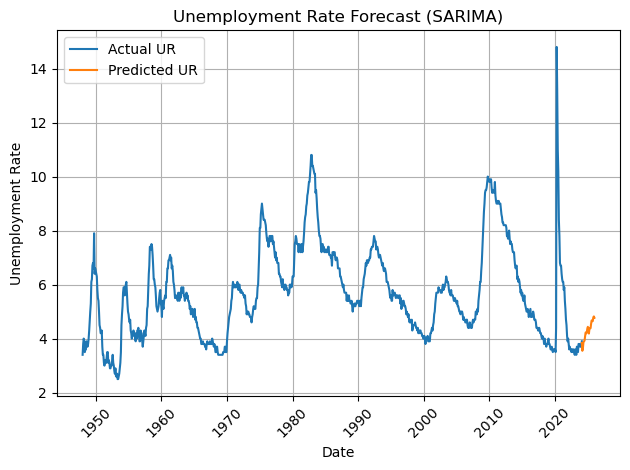

In [44]:
#Graph the 24 month predictions for Unemployment with SARIMA model

# Extract actual unemployment rate (if available) for comparison (optional)
actual_UR = df['UNRATE'].loc[from_date: pd.to_datetime(to_date) + pd.DateOffset(months=11)]  # Include one extra month for plotting

# Generate predicted dates for plotting
predicted_dates = [pd.to_datetime(to_date) + pd.DateOffset(months=i) for i in range(24)]  # Adjust for 12-month forecast

# Plot actual UR (if available)
if 'actual_UR' in locals():
  plt.plot(actual_UR.index, actual_UR.values, label='Actual UR')

# Plot predicted UR
plt.plot(predicted_dates, SAR_predicted, label='Predicted UR')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.title('Unemployment Rate Forecast (SARIMA)')

# Add legend (if actual UR is plotted)
if 'actual_UR' in locals():
  plt.legend()

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

## CONCLUSION: 
## 1) SARIMA 12 month training produced a 0.10112% MSE rate. The order was 7/4/3
## 2) SARIMA 24 month training produced a 0.1267% MSE rate. The order was 9/1/4
## 3) The seasonal_order setting was 1/0/1/12 for both models (stating Dec annual seasonality)

## 4) 12 month predicted UNRATE for SARIMA: 
#Predicted SARIMA UR on 2024-02-01 00:00:00: 3.63
#Predicted SARIMA UR on 2024-03-01 00:00:00: 3.56
#Predicted SARIMA UR on 2024-04-01 00:00:00: 3.6
#Predicted SARIMA UR on 2024-05-01 00:00:00: 3.61
#Predicted SARIMA UR on 2024-06-01 00:00:00: 3.63
#Predicted SARIMA UR on 2024-07-01 00:00:00: 3.66
#Predicted SARIMA UR on 2024-08-01 00:00:00: 3.71
#Predicted SARIMA UR on 2024-09-01 00:00:00: 3.73
#Predicted SARIMA UR on 2024-10-01 00:00:00: 3.75
#Predicted SARIMA UR on 2024-11-01 00:00:00: 3.78
#Predicted SARIMA UR on 2024-12-01 00:00:00: 3.8
#Predicted SARIMA UR on 2025-01-01 00:00:00: 3.82

## 4) 24 month predicted UNRATE for SARIMA:
#Predicted SARIMA UR on 2024-02-01 00:00:00: 3.84
#Predicted SARIMA UR on 2024-03-01 00:00:00: 3.55
#Predicted SARIMA UR on 2024-04-01 00:00:00: 3.65
#Predicted SARIMA UR on 2024-05-01 00:00:00: 3.87
#Predicted SARIMA UR on 2024-06-01 00:00:00: 3.9
#Predicted SARIMA UR on 2024-07-01 00:00:00: 3.93
#Predicted SARIMA UR on 2024-08-01 00:00:00: 4.09
#Predicted SARIMA UR on 2024-09-01 00:00:00: 4.23
#Predicted SARIMA UR on 2024-10-01 00:00:00: 4.19
#Predicted SARIMA UR on 2024-11-01 00:00:00: 4.21
#Predicted SARIMA UR on 2024-12-01 00:00:00: 4.36
#Predicted SARIMA UR on 2025-01-01 00:00:00: 4.44
#Predicted SARIMA UR on 2025-02-01 00:00:00: 4.36
#Predicted SARIMA UR on 2025-03-01 00:00:00: 4.19
#Predicted SARIMA UR on 2025-04-01 00:00:00: 4.37
#Predicted SARIMA UR on 2025-05-01 00:00:00: 4.39
#Predicted SARIMA UR on 2025-06-01 00:00:00: 4.38
#Predicted SARIMA UR on 2025-07-01 00:00:00: 4.55
#Predicted SARIMA UR on 2025-08-01 00:00:00: 4.67
#Predicted SARIMA UR on 2025-09-01 00:00:00: 4.64
#Predicted SARIMA UR on 2025-10-01 00:00:00: 4.65
#Predicted SARIMA UR on 2025-11-01 00:00:00: 4.79
#Predicted SARIMA UR on 2025-12-01 00:00:00: 4.82
#Predicted SARIMA UR on 2026-01-01 00:00:00: 4.77

## 5) Both SARIMA models predict long-term increasing UNRATEs. The starting point for the 12-month model was 3.6% and 0.3% less than actual and the 24-month was 3.84% and 0.06% less than actual. Actual UNRATE declined from 3.9% in Feb'24 to 3.8% in Mar'24 and they declined in both the 12-month and 24-month models. 

## 6) The RNN model reported an MSE of 0.019%. Much lower than the SARIMA errors. Lets take a look at the predictions. 

## Next step: Do the LSTM model because it is generally better at capturing long-term dependencies in the data. 

In [45]:
#Print RNN predicted values
print(rnn_predicted)

[5.242383718490601, 5.2215354442596436, 5.055586457252502, 5.039923787117004, 5.039775729179382, 5.041107535362244, 5.0402621030807495, 5.040226697921753, 5.040199518203735, 5.040225625038147, 5.0402220487594604, 5.040221691131592, 5.040221691131592, 4.889694690704346, 4.873006701469421, 4.875569462776184, 4.87696635723114, 5.02653169631958, 4.892713785171509, 4.873474657535553, 4.8746514320373535, 4.876965284347534, 4.876054584980011, 4.8760592341423035, 4.876018285751343, 4.8760499358177185, 4.876045823097229, 4.725034594535828, 4.708515405654907, 4.711061358451843, 4.712423384189606, 4.711498200893402, 4.711491227149963, 4.711476922035217, 4.711505174636841, 4.711500883102417, 4.711500525474548, 4.560078382492065, 4.5437294244766235, 4.5462594628334045, 4.547584652900696, 4.546655714511871, 4.5466508865356445, 4.546636939048767, 4.546665549278259, 4.546661615371704, 4.5466612577438354, 4.5466612577438354, 4.546661078929901, 4.5466612577438354, 4.5466612577438354, 4.5466612577438354,